In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time

In [2]:
# # Set the device
# # device = torch.device("cuda")
# device= torch.device("cpu")
# print("Device set: " + str(device))


In [3]:
def get_error(scores, labels):
	bs = scores.size(0)
	predicted_labels = scores.argmax(dim=1)
	indicator = (predicted_labels == labels)
	num_matches = indicator.sum()
	return 1 - num_matches.float() / bs

In [4]:
# Download MNIST dataset form pytorch
print("Checking for MNIST dataset.. ")


def check_mnist_dataset_exists(path_data='./data/'):
	import os.path
	flag_train_data = os.path.isfile(path_data + 'mnist/train_data.pt')
	flag_train_label = os.path.isfile(path_data + 'mnist/train_label.pt')
	flag_test_data = os.path.isfile(path_data + 'mnist/test_data.pt')
	flag_test_label = os.path.isfile(path_data + 'mnist/test_label.pt')
	if flag_train_data == False or flag_train_label == False or flag_test_data == False or flag_test_label == False:
		print('MNIST dataset missing - downloading...')
		import torchvision
		import torchvision.transforms as transforms
		trainset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=True,
		                                      download=True, transform=transforms.ToTensor())
		testset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=False,
		                                     download=True, transform=transforms.ToTensor())
		train_data = torch.Tensor(60000, 28, 28)
		train_label = torch.LongTensor(60000)
		for idx, example in enumerate(trainset):
			train_data[idx] = example[0].squeeze()
			train_label[idx] = example[1]
		torch.save(train_data, path_data + 'mnist/train_data.pt')
		torch.save(train_label, path_data + 'mnist/train_label.pt')
		test_data = torch.Tensor(10000, 28, 28)
		test_label = torch.LongTensor(10000)
		for idx, example in enumerate(testset):
			test_data[idx] = example[0].squeeze()
			test_label[idx] = example[1]
		torch.save(test_data, path_data + 'mnist/test_data.pt')
		torch.save(test_label, path_data + 'mnist/test_label.pt')
	train_data = torch.load(path_data + 'mnist/train_data.pt')
	train_label = torch.load(path_data + 'mnist/train_label.pt')
	test_data = torch.load(path_data + 'mnist/test_data.pt')
	test_label = torch.load(path_data + 'mnist/test_label.pt')
	return train_data, train_label, test_data, test_label

Checking for MNIST dataset.. 


In [5]:
train_data, train_label, test_data, test_label = check_mnist_dataset_exists()

In [6]:
# MLP

print("Creating MLP")

Creating MLP


In [7]:
class MLP(nn.Module):
	"""
	Strictly to be used for MNIST data set only due to input/output size
	"""
	layers = 2

	def __init__(self, layers=2):
		super(MLP, self).__init__()

		self.layers = layers

		# 2 layer net
		if layers == 2:
			self.layer1 = nn.Linear(784, 50, bias=True)
			self.layer2 = nn.Linear(50, 10, bias=True)

		# 3 layer net
		if layers == 3:
			self.layer1 = nn.Linear(784, 50, bias=True)
			self.layer2 = nn.Linear(50, 50, bias=True)
			self.layer3 = nn.Linear(50, 10, bias=True)

	def forward(self, x):

		if self.layers == 2:
			y = self.layer1(x)
			return self.layer2(y)

		if self.layers == 3:
			y = self.layer1(x)
			y_hat = torch.relu(y)
			z = self.layer2(y_hat)
			z_hat = torch.relu(z)
			return self.layer3(z_hat)

In [8]:
mlp_2_layers = MLP(2)
mlp_3_layers = MLP(3)
print(mlp_2_layers)
print(mlp_3_layers)
# mlp_2_layers = mlp_2_layers.to(device)
# mlp_3_layers = mlp_3_layers.to(device)


MLP(
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)
MLP(
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=10, bias=True)
)


In [9]:
print("MLP ready")

MLP ready


In [10]:
# Make LeNet NN
# source: deep learning lecture

print("Creating LeNet")


Creating LeNet


In [11]:

class LeNet(nn.Module):
	"""
	Strictly to be used for MNIST data set only due to input/output size
	"""

	def __init__(self):
		super(LeNet, self).__init__()

		# CL1:   28 x 28  -->    50 x 28 x 28
		self.conv1 = nn.Conv2d(1, 50, kernel_size=3, padding=1)
		# MP1: 50 x 28 x 28 -->    50 x 14 x 14
		self.pool1 = nn.MaxPool2d(2, 2)
		# CL2:   50 x 14 x 14  -->    100 x 14 x 14
		self.conv2 = nn.Conv2d(50, 100, kernel_size=3, padding=1)
		# MP2: 100 x 14 x 14 -->    100 x 7 x 7
		self.pool2 = nn.MaxPool2d(2, 2)
		# LL1:   100 x 7 x 7 = 4900 -->  100
		self.linear1 = nn.Linear(4900, 100)
		# LL2:   100  -->  10
		self.linear2 = nn.Linear(100, 10)

	def forward(self, x):
		# CL1:   28 x 28  -->    50 x 28 x 28
		x = self.conv1(x)
		x = F.relu(x)
		# MP1: 50 x 28 x 28 -->    50 x 14 x 14
		x = self.pool1(x)
		# CL2:   50 x 14 x 14  -->    100 x 14 x 14
		x = self.conv2(x)
		x = F.relu(x)
		# MP2: 100 x 14 x 14 -->    100 x 7 x 7
		x = self.pool2(x)
		# LL1:   100 x 7 x 7 = 4900  -->  100
		x = x.view(-1, 4900)
		x = self.linear1(x)
		x = F.relu(x)
		# LL2:   4900  -->  10
		x = self.linear2(x)

		return x

In [12]:
net = LeNet()
print(net)
# net = net.to(device)

LeNet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=4900, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)


In [13]:
print("LeNet ready")

LeNet ready


In [14]:
# Set hyper parameters
# 1. loss function
# 2. learning rate
# 3. batch size

In [15]:
criterion = nn.CrossEntropyLoss()
criterion_m2 = nn.CrossEntropyLoss()
criterion_m3 = nn.CrossEntropyLoss()
lr = 0.25
bs = 50
mean = train_data.mean()
std = train_data.std()

In [16]:
def eval_on_test_set():

	running_error = 0
	running_error_m2 = 0
	running_error_m3 = 0
	num_batches = 0

	for i in range(0, 10000, bs):
		minibatch_data = test_data[i:i + bs].unsqueeze(dim=1)
		minibatch_data_m = test_data[i:i + bs]
		minibatch_label = test_label[i:i + bs]

		# minibatch_data = minibatch_data.to(device)
		# minibatch_data_m = minibatch_data_m.to(device)
		# minibatch_label = minibatch_label.to(device)

		inputs = (minibatch_data - mean) / std
		inputs_m2 = minibatch_data_m.view(bs, 784)
		inputs_m3 = minibatch_data_m.view(bs, 784)
	
		scores = net(inputs)
		scores_m2 = mlp_2_layers(inputs_m2)
		scores_m3 = mlp_3_layers(inputs_m3)
	
		error = get_error(scores, minibatch_label)
		error_m2 = get_error(scores_m2, minibatch_label)
		error_m3 = get_error(scores_m3, minibatch_label)
	
		running_error += error.item()
		running_error_m2 += error_m2.item()
		running_error_m3 += error_m3.item()
		num_batches += 1
	
	total_error = running_error / num_batches
	total_error_m2 = running_error_m2 / num_batches
	total_error_m3 = running_error_m3 / num_batches
	
	print('error rate on test set (lenet) =', total_error * 100, 'percent')
	print('error rate on test set (m2) =', total_error_m2 * 100, 'percent')
	print('error rate on test set (m3) =', total_error_m3 * 100, 'percent')
 
	return total_error_m2*100,total_error_m3*100,total_error*100

In [17]:
start = time.time()

store_lr=lr
store_bs=bs

store_loss=[]
store_loss_m2=[]
store_loss_m3=[]
store_error=[]
store_error_m2=[]
store_error_m3=[]
store_test_error=[]
store_test_error_m2=[]
store_test_error_m3=[]

for epoch in range(1, 5+1):

	if not epoch % 5:
		lr = lr / 1.5

	optimizer = torch.optim.SGD(net.parameters(), lr=lr)
	optimizer_m2 = torch.optim.SGD(mlp_2_layers.parameters(), lr=lr)
	optimizer_m3 = torch.optim.SGD(mlp_3_layers.parameters(), lr=lr)

	running_loss = 0
	running_loss_m2 = 0
	running_loss_m3 = 0
	running_error = 0
	running_error_m2 = 0
	running_error_m3 = 0
	num_batches = 0

	shuffled_indices = torch.randperm(60000)
 

	for count in range(0, 60000, bs):
		# FORWARD AND BACKWARD PASS

		optimizer.zero_grad()
		optimizer_m2.zero_grad()
		optimizer_m3.zero_grad()
		indices = shuffled_indices[count:count + bs]
		minibatch_data = train_data[indices].unsqueeze(dim=1)
		minibatch_data_m = train_data[indices]
		minibatch_label = train_label[indices]
		# minibatch_data = minibatch_data.to(device)
		# minibatch_data_m = minibatch_data_m.to(device)
		# minibatch_label = minibatch_label.to(device)

		inputs = (minibatch_data - mean) / std 
		inputs.requires_grad_()
		inputs_m2 = minibatch_data_m.view(bs, 784)
		inputs_m2.requires_grad_()
		inputs_m3 = minibatch_data_m.view(bs, 784)
		inputs_m3.requires_grad_()
	
		scores = net(inputs)
		scores_m2 = mlp_2_layers(inputs_m2)
		scores_m3 = mlp_3_layers(inputs_m3)
	
		loss = criterion(scores, minibatch_label)
		loss_m2 = criterion(scores_m2, minibatch_label)
		loss_m3 = criterion(scores_m3, minibatch_label)
	
		loss.backward()
		loss_m2.backward()
		loss_m3.backward()
	
		optimizer.step()
		optimizer_m2.step()
		optimizer_m3.step()
		# COMPUTE STATS

		running_loss += loss.detach().item()
		running_loss_m2 += loss_m2.detach().item()
		running_loss_m3 += loss_m3.detach().item()
	
		error = get_error(scores.detach(), minibatch_label)
		error_m2 = get_error(scores_m2.detach(), minibatch_label)
		error_m3 = get_error(scores_m3.detach(), minibatch_label)
	
		running_error += error.item()
		running_error_m2 += error_m2.item()
		running_error_m3 += error_m3.item()
		num_batches += 1

	# AVERAGE STATS THEN DISPLAY

	total_loss = running_loss / num_batches
	total_loss_m2 = running_loss_m2 / num_batches
	total_loss_m3 = running_loss_m3 / num_batches

	store_loss.append(total_loss)
	store_loss_m2.append(total_loss_m2)
	store_loss_m3.append(total_loss_m3)
 
	total_error = running_error / num_batches
	total_error_m2 = running_error_m2 / num_batches
	total_error_m3 = running_error_m3 / num_batches
	elapsed = (time.time() - start) / 60

	store_error.append(total_error*100)
	store_error_m2.append(total_error_m2*100)
	store_error_m3.append(total_error_m3*100)

	print('epoch=', epoch, '\t time=', elapsed, 'min', '\t lr=', lr,
	      '\t loss=', total_loss, '\t error=', total_error * 100, 'percent')
	print('(m2) epoch=', epoch, '\t time=', elapsed, 'min', '\t lr=', lr,
	      '\t loss=', total_loss_m2, '\t error=', total_error_m2 * 100, 'percent')
	print('(m3) epoch=', epoch, '\t time=', elapsed, 'min', '\t lr=', lr,
	      '\t loss=', total_loss_m3, '\t error=', total_error_m3 * 100, 'percent')

	store_all_test_error=eval_on_test_set()
	store_test_error.append(store_all_test_error[2])
	store_test_error_m2.append(store_all_test_error[0])
	store_test_error_m3.append(store_all_test_error[1])

epoch= 1 	 time= 2.172710692882538 min 	 lr= 0.25 	 loss= 0.17652298012457324 	 error= 5.6999998937050504 percent
(m2) epoch= 1 	 time= 2.172710692882538 min 	 lr= 0.25 	 loss= 0.39074076123535634 	 error= 11.203333760301271 percent
(m3) epoch= 1 	 time= 2.172710692882538 min 	 lr= 0.25 	 loss= 0.33363558815481764 	 error= 10.418333604931831 percent
error rate on test set (lenet) = 1.1599997282028198 percent
error rate on test set (m2) = 8.950000584125519 percent
error rate on test set (m3) = 5.010000079870224 percent
epoch= 2 	 time= 4.431665019194285 min 	 lr= 0.25 	 loss= 0.042837396866549776 	 error= 1.303332914908727 percent
(m2) epoch= 2 	 time= 4.431665019194285 min 	 lr= 0.25 	 loss= 0.32045334059745073 	 error= 9.105000401536625 percent
(m3) epoch= 2 	 time= 4.431665019194285 min 	 lr= 0.25 	 loss= 0.13435691852588205 	 error= 4.083333373069763 percent
error rate on test set (lenet) = 1.2499996423721313 percent
error rate on test set (m2) = 8.390000134706497 percent
error rate

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


In [22]:

def plot_epoch_vs_test_error(lr,bs,test_error,test_error_m2,test_error_m3):
  epoch = list(range(1,len(test_error_m2)+1))
  fig = plt.figure(figsize=(8,8))
  fig = sns.lineplot(x=epoch,y=test_error)
  fig = sns.lineplot(x=epoch,y=test_error_m2)
  fig = sns.lineplot(x=epoch,y=test_error_m3)
  plt.xlabel('number of Epoch')
  plt.ylabel('Test Error (Percentage)')
  plt.title(f'Epoch Vs Test Error (learning rate of {lr} & batch size of {bs})\n')
  plt.legend(['LeNet','2 Layer MLP','3 Layer MLP'],loc='best')

  # fig.tight_layout()

def plot_epoch_vs_network_error(lr,bs,network_name,error,test_error):
  epoch = list(range(1,len(test_error)+1))
  fig = plt.figure(figsize=(8,8))
  fig = sns.lineplot(x=epoch,y=error)
  fig = sns.lineplot(x=epoch,y=test_error)
  plt.xlabel('number of Epoch')
  plt.ylabel('Error (Percentage)')
  plt.title(f'Epoch Vs {network_name} Error (learning rate of {lr} & batch size of {bs})\n')
  plt.legend(['Training','Testing'],loc='best')

  # fig.tight_layout()

def plot_epoch_vs_loss(lr,bs,loss,loss_m2,loss_m3):
  epoch = list(range(1,len(store_loss_m2)+1))
  fig = plt.figure(figsize=(8,8))
  fig = sns.lineplot(x=epoch,y=loss)
  fig = sns.lineplot(x=epoch,y=loss_m2)
  fig = sns.lineplot(x=epoch,y=loss_m3)
  plt.xlabel('number of Epoch')
  plt.ylabel('Cross Entropy Loss')
  plt.title(f'Epoch Vs Loss (learning rate of {lr} & batch size of {bs})\n')
  plt.legend(['LeNet','2 Layer MLP','3 Layer MLP'],loc='best')

  # fig.tight_layout()
  
def plot_loss_vs_error(lr,bs,loss,error,loss_m2,error_m2,loss_m3,error_m3):
  # epoch = list(range(1,len(store_test_error_m2)+1))
  fig = plt.figure(figsize=(8,8))
  fig = sns.lineplot(x=loss,y=error)
  fig = sns.lineplot(x=loss_m2,y=error_m2)
  fig = sns.lineplot(x=loss_m3,y=error_m3)
  plt.xlabel('Training Loss')
  plt.ylabel('Training Error (Percentage)')
  plt.title(f'Loss Vs Error (learning rate of {lr} & batch size of {bs})\n')
  plt.legend(['LeNet','2 Layer MLP','3 Layer MLP'],loc='best')

  # fig.tight_layout()

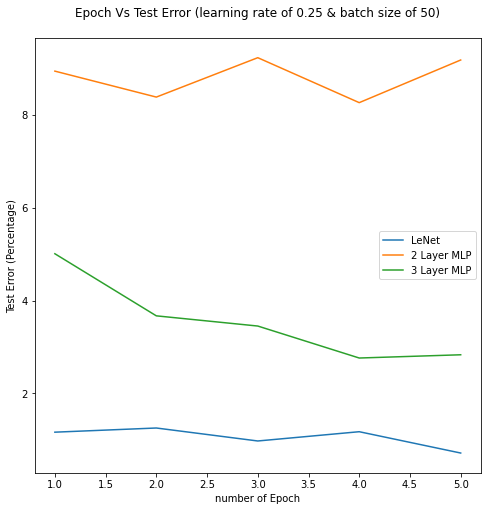

In [23]:
plot_epoch_vs_test_error(store_lr,store_bs,store_test_error,store_test_error_m2,store_test_error_m3)

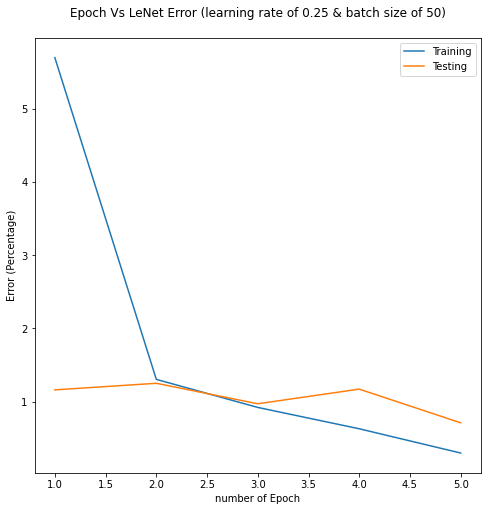

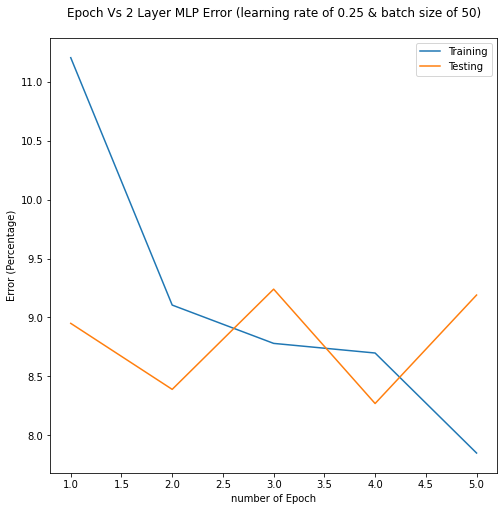

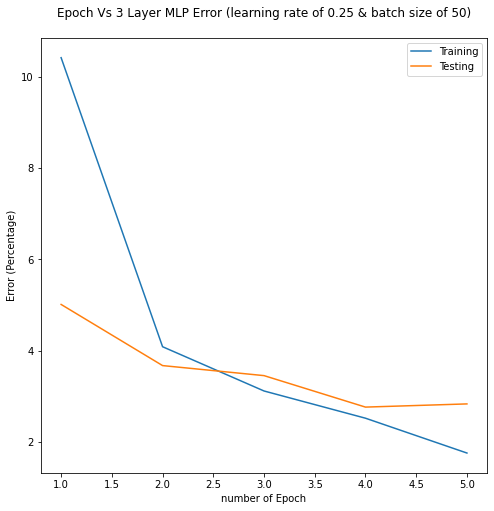

In [32]:
plot_epoch_vs_network_error(store_lr,store_bs,'LeNet',store_error,store_test_error)
plot_epoch_vs_network_error(store_lr,store_bs,'2 Layer MLP',store_error_m2,store_test_error_m2)
plot_epoch_vs_network_error(store_lr,store_bs,'3 Layer MLP',store_error_m3,store_test_error_m3)


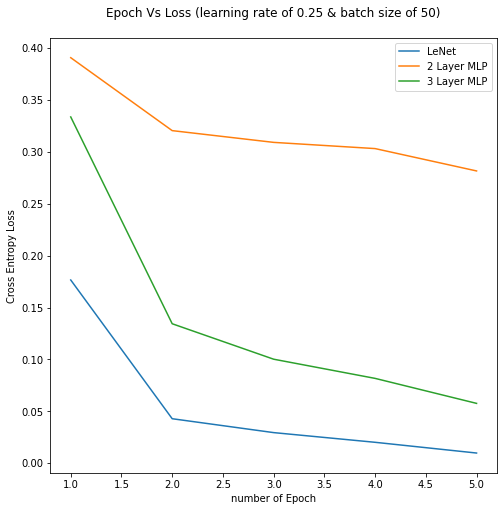

In [33]:
plot_epoch_vs_loss(store_lr,store_bs,store_loss,store_loss_m2,store_loss_m3)

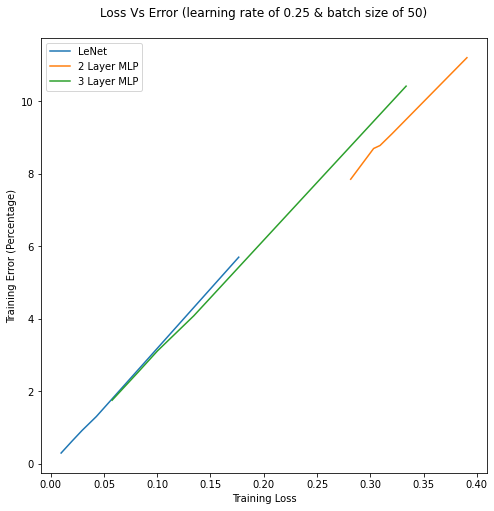

In [34]:
plot_loss_vs_error(store_lr,store_bs,store_loss,store_error,store_loss_m2,store_error_m2,store_loss_m3,store_error_m3)